### Data Modeling and Evaluation

In [1]:
# Required package.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import logging

from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

%matplotlib inline

# Random seed for replicating experiments.
RANDOM_SEED = 19730115
rng = np.random.RandomState(RANDOM_SEED)

# Vectorizer model names.
VECTORIZER_NAMES = [
    "cv_s50",
    "tv_s50",
    "fasttext_cbow_s50",
    "fasttext_skip_s50",
    "glove_s50",
    "wang2vec_cbow_s50",
    "wang2vec_skip_s50",
    "word2vec_cbow_s50",
    "word2vec_skip_s50",
    "bert",
]

# logging configuration.
log_fmt = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
logging.basicConfig(level=logging.INFO, format=log_fmt)
logging.info("Required packages installed.")

Required packages installed.


In [2]:
def load_pickle_dataset(path):
    """Read pickle.

    Args:
        path (str): The full dataset file.

    Returns:
        features(array) and target(array):
    """

    # Get the features and target variable.
    data = pd.read_pickle(path)
    features, target = data.iloc[:, 1:-1].values, data.iloc[:, -1].values

    return features, target


In [3]:
def train_model(X, y, estimator=None, distributions=None):
    """Split the dataframe in training and testing partitions.


    Args:
        X (Numpy array):
        y (Numpy array):
        estimator (Sklearn model):
        distributions (dict):

    Returns:
        Best estimator, mean test score and


    """

    kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=rng)

    search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=distributions,
        scoring="f1_micro",
        refit=True,
        verbose=0,
        random_state=rng,
    )

    model = search.fit(X, y)
    return (
        model.best_estimator_,
        model.cv_results_["mean_test_score"],
        model.cv_results_["mean_score_time"],
    )


def test_model(model, X_test, y_test):
    """Test model."""
    y_pred = model.predict(X_test)
    return f1_score(y_pred, y_test, average="micro")


def train_test_model(vectorizer_names, estimator, estimator_distributions):
    """"""

    logger = logging.getLogger(__name__)
    train_scores, train_times, test_scores = [], [], []
    for name in vectorizer_names:
        logger.info(f"Load {name} vectorized database.")
        reviews_train_features, reviews_train_target = load_pickle_dataset(
            f"../data/processed/buscape_reviews_train_dataset_{name}.pkl"
        )
        reviews_test_features, reviews_test_target = load_pickle_dataset(
            f"../data/processed/buscape_reviews_test_dataset_{name}.pkl"
        )

        logger.info(f"Train {name} with vectorized database.")
        model, scores, times = train_model(
            reviews_train_features,
            reviews_train_target,
            estimator,
            estimator_distributions,
        )
        train_scores.append(list(scores))
        train_times.append(list(times))

        logger.info(f"Test {name} with vectorized database.")
        test_scores.append(
            test_model(model, reviews_test_features, reviews_test_target)
        )

    return train_scores, train_times, test_scores


def plot_train_test_scores(train_scores, train_times, test_scores, xlabels):
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.xticks(rotation=90)
    fig.suptitle("Feature Extraction Method Comparison in Train Phase")
    _ = plt.boxplot(train_scores)
    ax.set_xticklabels(xlabels)
    ax.set_ylabel("F1-score")
    ax.set_xlabel("Feature Extraction Methods")
    plt.show()

    fig, ax = plt.subplots(figsize=(20, 10))
    plt.xticks(rotation=90)
    plt.ylim(0.0, 10.0)
    fig.suptitle("Feature Extraction Method Comparison in Train Phase")
    _ = plt.boxplot(train_times)
    ax.set_xticklabels(xlabels)
    ax.set_ylabel("Fit Mean Time (s)")
    ax.set_xlabel("Feature Extraction Methods")
    plt.show()

    fig, ax = plt.subplots(figsize=(20, 10))
    plt.xticks(rotation=90)
    fig.suptitle("Feature Extraction Method Comparison in Test Step")
    bars = plt.bar(xlabels, test_scores)
    ax.set_ylabel("F1-score")
    ax.set_xlabel("Feature Extraction Methods")
    ax.bar_label(bars)
    plt.show()


In [4]:
# source: https://scikit-learn.org/stable/modules/grid_search.html.
knn_estimator = KNeighborsClassifier()
knn_estimator_distributions = {
    "n_neighbors": list(range(1, 31, 2)),
    "weights": ["uniform", "distance"],
}

# source: https://scikit-learn.org/stable/modules/grid_search.html
svm_estimator = SVC()
svm_estimator_distributions = [
    {"C": [1, 10, 100, 1000], "kernel": ["linear"]},
    {"C": [1, 10, 100, 1000], "gamma": [0.001, 0.0001], "kernel": ["rbf"]},
]


Load cv_s50 vectorized database.
Train cv_s50 with vectorized database.
Test cv_s50 with vectorized database.
Load tv_s50 vectorized database.
Train tv_s50 with vectorized database.
Test tv_s50 with vectorized database.
Load fasttext_cbow_s50 vectorized database.
Train fasttext_cbow_s50 with vectorized database.
Test fasttext_cbow_s50 with vectorized database.
Load fasttext_skip_s50 vectorized database.
Train fasttext_skip_s50 with vectorized database.
Test fasttext_skip_s50 with vectorized database.
Load glove_s50 vectorized database.
Train glove_s50 with vectorized database.
Test glove_s50 with vectorized database.
Load wang2vec_cbow_s50 vectorized database.
Train wang2vec_cbow_s50 with vectorized database.
Test wang2vec_cbow_s50 with vectorized database.
Load wang2vec_skip_s50 vectorized database.
Train wang2vec_skip_s50 with vectorized database.
Test wang2vec_skip_s50 with vectorized database.
Load word2vec_cbow_s50 vectorized database.
Train word2vec_cbow_s50 with vectorized datab

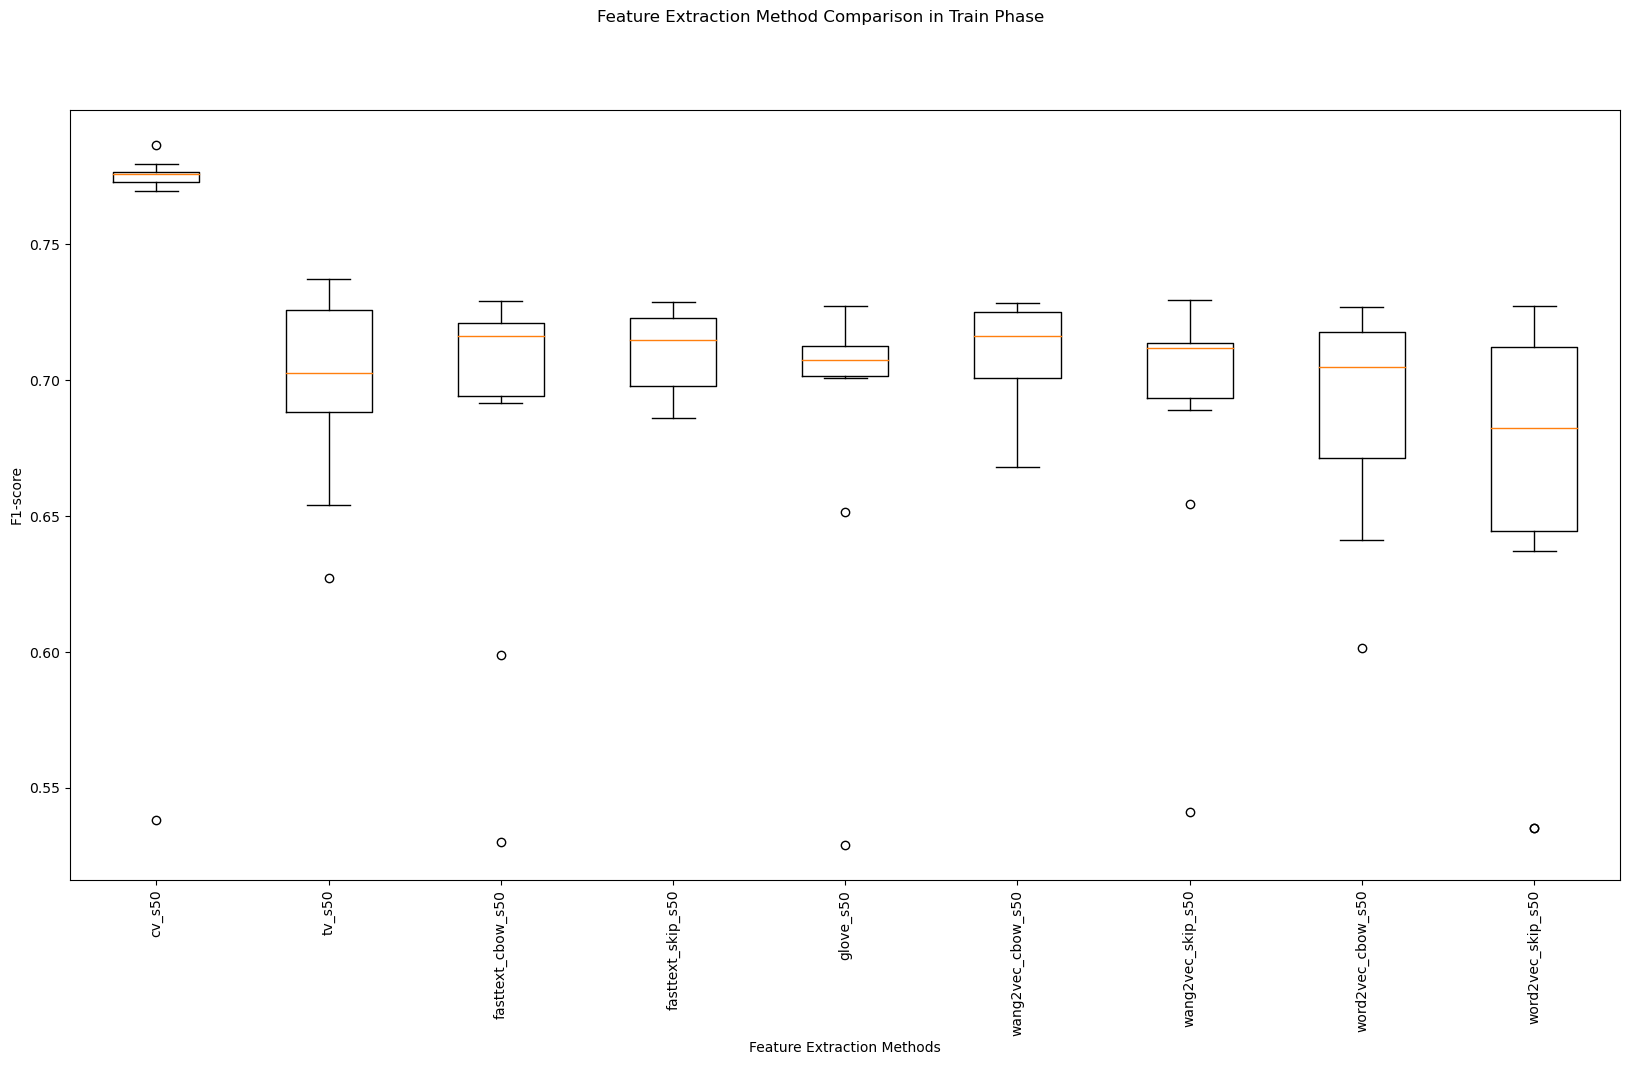

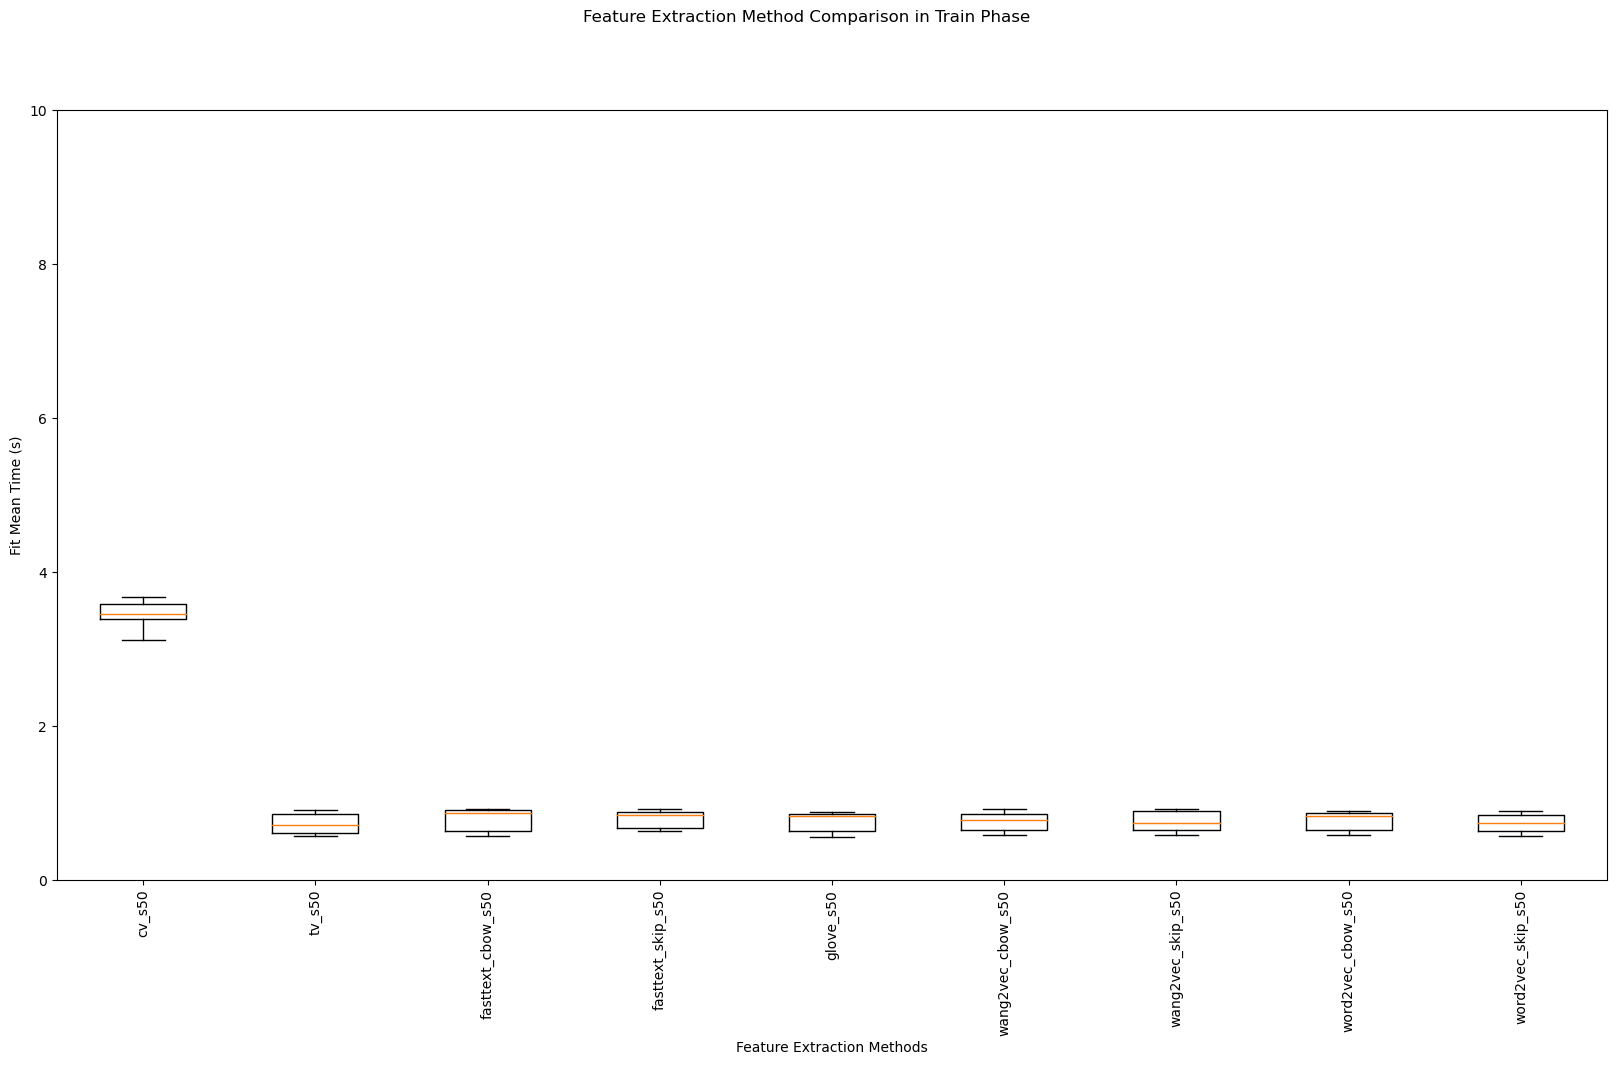

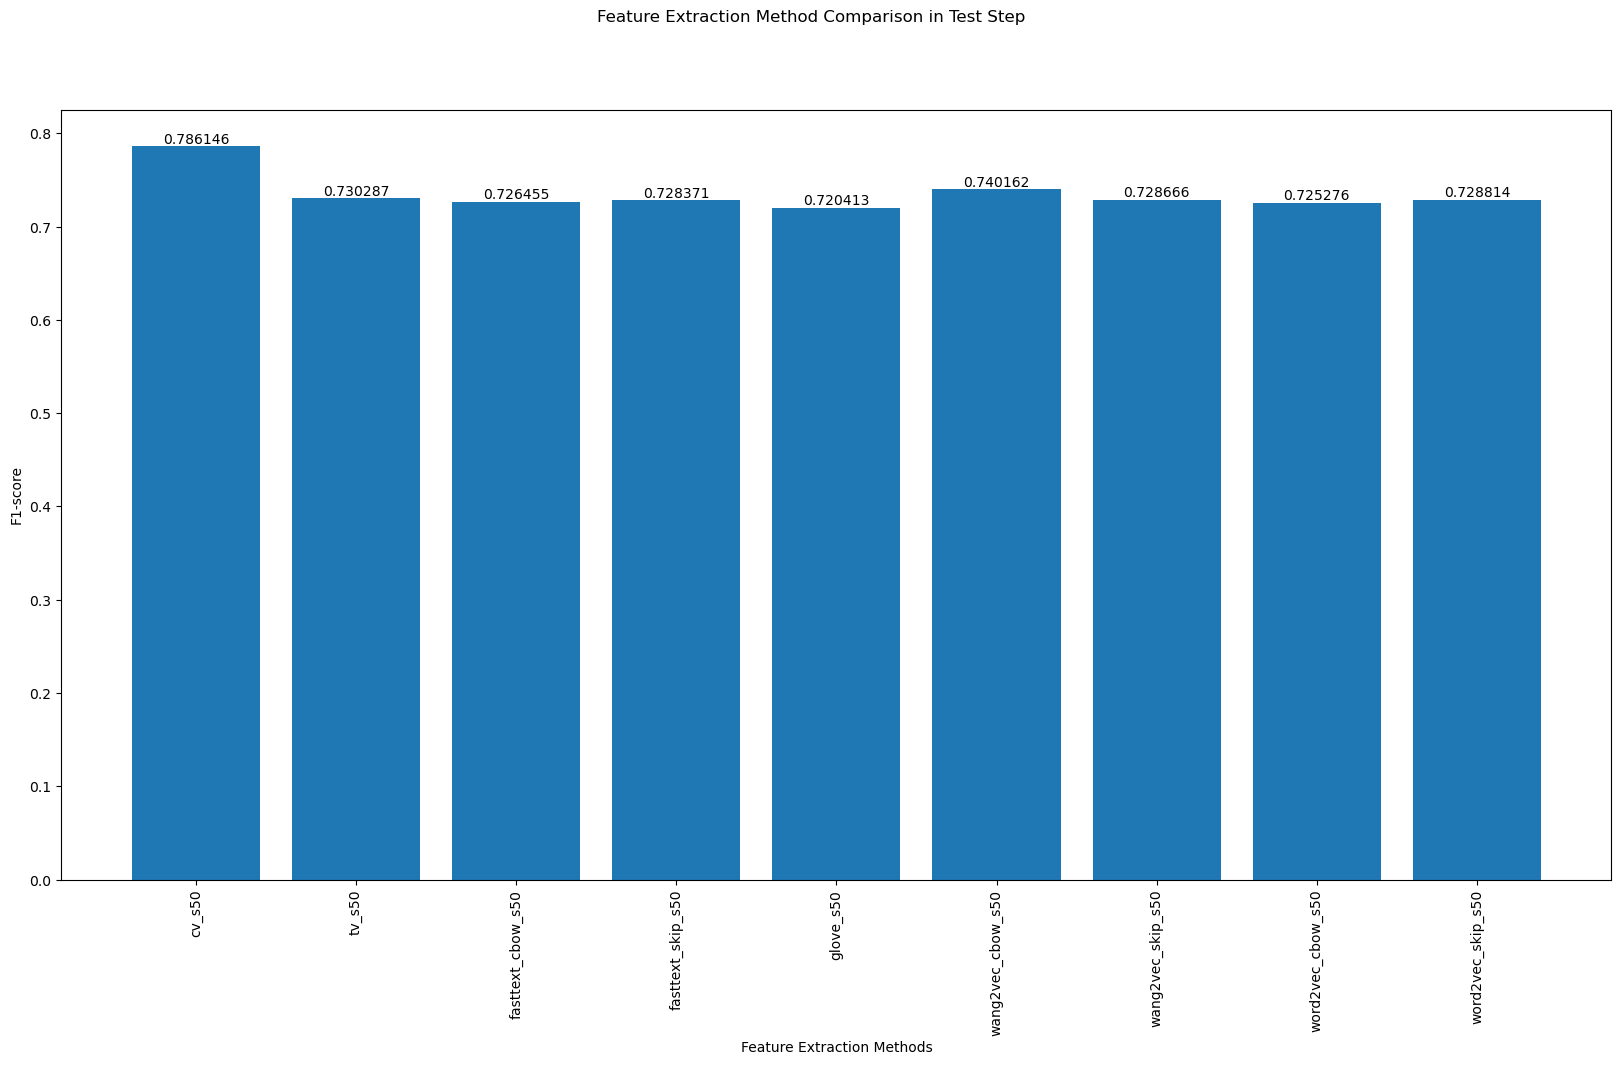

In [5]:
# baseline estimator
train_scores, train_times, test_scores = train_test_model(
    VECTORIZER_NAMES, knn_estimator, knn_estimator_distributions
)
plot_train_test_scores(train_scores, train_times, test_scores, VECTORIZER_NAMES)


In [6]:
# svm estimator.
train_scores, train_times, test_scores = train_test_model(
    VECTORIZER_NAMES, svm_estimator, svm_estimator_distributions
)
plot_train_test_scores(train_scores, train_times, test_scores, VECTORIZER_NAMES)

Load cv_s100 vectorized database.
Train cv_s100 with vectorized database.
